# MIE524 - Assignment 4
Please complete this notebook for Assignment 4.

## Q1 - PageRank

### Spark Setup

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u432-ga~us1-0ubuntu2~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm import tqdm

%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize Spark Context

In [3]:
# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Load Data

In [4]:
# loads the input file as an RDD, with each element being a string
# of the form "source destination" where source and destination
# are node id's representing the directed edge from node source
# to node destination. Note that the elements of this RDD are string
# types, hence you will need to map them to integers later.

lines = sc.textFile("q1-graph-full.txt")

### a) PageRank Implementation

In [5]:
## inspried lynnezixuan from github. UTL: https://github.com/lynnezixuan/CS246/blob/master/pagerank.py ##
## does not explicitly use matrix M but it collects relationships directly and assumes uniform distribution across neighbors.
## Collects all nodes and neighbors into memory, which might not scale for large graphs.

class my_PageRank:
    def __init__(self, lines, num_iterations, beta):
        """
        Initializes the my_PageRank object
        lines: Input data RDD containing source-destination pairs.
        num_iterations: Number of iterations for the PageRank algorithm.
        beta: Damping factor (teleportation probability).
        """
        self.lines = lines
        self.num_iterations = num_iterations
        self.beta = beta

        # Adjacency list representing the graph.
        self.M = self.create_M()

    def create_M(self):
        """
        Generate the source destination matrix M
        """

        # TODO: YOUR CODE HERE
        relation = self.lines.map(lambda line: line.rstrip().split('\t')) \
                             .map(lambda pair: (pair[0], pair[1])) \
                             .distinct() \
                             .groupByKey() \
                             .mapValues(list)
        M = relation.collect()
        return M

    def compute_PageRank(self):
        """
        Run the entire PageRank algorithm
        """
        # 1. Initialize r^0
        n = len(self.M)
        r = {node: 1.0 / n for node, _ in self.M}
        # 2. Iteratively compute r^i
        for _ in range(self.num_iterations):
          new_r = {node: (1 - self.beta) / n for node, _ in self.M}  # Start with teleport probability

          for node, neighbors in self.M:
              rank_contribution = r[node] / len(neighbors) if neighbors else 0
              for neighbor in neighbors:
                  new_r[neighbor] += self.beta * rank_contribution
          r = new_r  # Update ranks
        return r

In [6]:
# initialize my_PageRank object
pg = my_PageRank(lines = lines, num_iterations = 40, beta = 0.8)

### b) Compute the top 5 node ids with the highest PageRank scores.

In [7]:
# TODO: YOUR CODE HERE
ranks = pg.compute_PageRank()

top = sorted(ranks.items(), key=lambda pair: -pair[1])[:5]
print("\nTop 5 nodes:")
print(top)


Top 5 nodes:
[('263', 0.002020291181518219), ('537', 0.0019433415714531503), ('965', 0.0019254478071662631), ('243', 0.0018526340162417312), ('285', 0.0018273721700645146)]


### c) Compute the top 5 node ids with the lowest PageRank scores.

In [8]:
# TODO: YOUR CODE HERE
bottom = sorted(ranks.items(), key=lambda pair: pair[1])[:5]
print("Bottom 5 nodes:")
print(bottom)

Bottom 5 nodes:
[('558', 0.00032860185252152975), ('93', 0.00035135689375165774), ('62', 0.00035314810510596285), ('424', 0.0003548153864930145), ('408', 0.00038779848719291705)]


In [9]:
# stop the spark instance
sc.stop()

## Q2 - K-Means

In [10]:
# create new spark instance

# create the session
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Load Data

In [11]:
# loads the input file as an RDD, with each element being a string
documents = sc.textFile("q2-data.txt")
c1 = sc.textFile("q2-c1.txt")
c2 = sc.textFile("q2-c2.txt")

### Implement K-Means

In [12]:
# function to compute Euclidean distance between point A and B
def euclidean_distance(A, B):
    return np.sqrt(np.sum(np.square(np.subtract(A, B))))

# function to compute cost function phi
def compute_phi(dataset, centroids):
    # TODO: YOUR CODE HERE
    cost = 0
    for point in dataset:
        min_dist = float('inf')
        for centroid in centroids:
            dist = euclidean_distance(point, centroid)
            if dist < min_dist:
                min_dist = dist
        cost += min_dist ** 2
    return cost

In [13]:
# function to compute Manhattan distance between point A and B
def manhattan_distance(A, B):
    return np.sum(np.abs(np.subtract(A, B)))

# function to compute cost function psi
def compute_psi(dataset, centroids):
    # TODO: YOUR CODE HERE
    cost = 0
    for point in dataset:
        min_dist = float('inf')
        for centroid in centroids:
            dist = manhattan_distance(point, centroid)
            if dist < min_dist:
                min_dist = dist
        cost += min_dist
    return cost

In [14]:
class my_kmeans:
    def __init__(self, data, centroids, k, max_iter, distance_measure):
        """
        Initializes the my_PageRank object
        Args:
            data: RDD containing the dataset points.
            centroids: RDD containing the initial centroids.
            k: Number of clusters.
            max_iter: Maximum number of iterations for the K-Means algorithm.
            distance_measure: Function to compute the distance (e.g., euclidean_distance or manhattan_distance).
        """
        self.data = data
        self.centroids = centroids
        self.k = k
        self.max_iter = max_iter

        self.distance_measure = distance_measure

    def run_kmeans(self):
        """
        Run the entire K-Means algorithm, return list of centroids, list of assignments, and list of costs

        """

        # TODO: YOUR CODE HERE
        # Collect data and centroids as lists
        data_list = self.data.map(lambda line: np.array(list(map(float, line.split())))).collect()
        centroids = self.centroids.map(lambda line: np.array(list(map(float, line.split())))).collect()

        # store cost values
        costs = []

        for _ in range(self.max_iter):
            # Step 1: Assign clusters
            assignments = []
            cost = 0

            for point in data_list:
                # Initialize minimum distance as infinity
                min_dist = float('inf')
                # Initialize the cluster assignment
                assigned_cluster = -1

                # Find the closest centroid
                for i, centroid in enumerate(centroids):
                    # Calculate distance to the centroid
                    dist = self.distance_measure(point, centroid)
                    if dist < min_dist:
                      # Update minimum distance and cluster assignment if closer centroid found
                      min_dist = dist
                      assigned_cluster = i

                assignments.append(assigned_cluster)

                # Add to cost based on the distance measure
                if self.distance_measure == euclidean_distance:
                    cost += min_dist ** 2  # Use squared distance for Euclidean
                else:
                    cost += min_dist  # Use linear distance for Manhattan

            costs.append(cost)

            # Step 2: Update centroids
            new_centroids = []
            for i in range(self.k):
                # Find all points assigned to the current cluster
                cluster_points = [
                    data_list[idx] for idx, cluster in enumerate(assignments) if cluster == i
                ]
                if cluster_points:
                  # If the cluster is not empty, compute the new centroid using mean
                    new_centroids.append(np.mean(cluster_points, axis=0))
                else:
                    new_centroids.append(centroids[i])  # Retain previous centroid if no points are assigned
            # Update
            centroids = new_centroids

        return centroids, assignments, costs

### a) Using Euclidean distance to compute phi(i) for every iteration i.

In [15]:
# initialize my_kmeans class with Euclidean Distance with centroids c1 and run the K-means algorithm
km1 = my_kmeans(data=documents, centroids=c1, k=10, max_iter=20, distance_measure=euclidean_distance)
centroids1, assignments1, costs1 = km1.run_kmeans()

# initialize my_kmeans class with Euclidean Distance with centroids c2 and run the K-means algorithm
km2 = my_kmeans(data=documents, centroids=c2, k=10, max_iter=20, distance_measure=euclidean_distance)
centroids2, assignments2, costs2 = km2.run_kmeans()

In [16]:
# Get a list of costs phi
list_of_costs1 = costs1
print("List of costs for c1.txt:")
print(list_of_costs1)

list_of_costs2 = costs2
print("List of costs for c2.txt:")
print(list_of_costs2)

List of costs for c1.txt:
[623660345.3064235, 509862908.29754597, 485480681.8720084, 463997011.6850107, 460969266.57299405, 460537847.98277014, 460313099.65354246, 460003523.88940686, 459570539.3177354, 459021103.34229016, 458490656.1919808, 457944232.5879742, 457558005.1986796, 457290136.3523032, 457050555.0595639, 456892235.61535746, 456703630.7370357, 456404203.0189769, 456177800.54199505, 455986871.02734846]
List of costs for c2.txt:
[438747790.027918, 249803933.62600294, 194494814.406314, 169804841.45154336, 156295748.806276, 149094208.10896608, 142508531.61961588, 132303869.40653005, 117170969.8371908, 108547377.17857017, 102237203.31799614, 98278015.74975717, 95630226.12177445, 93793314.05119292, 92377131.96821108, 91541606.25423913, 91045573.83042422, 90752240.10140836, 90470170.18122767, 90216416.17563146]


Use the below cell to plot the graphs.

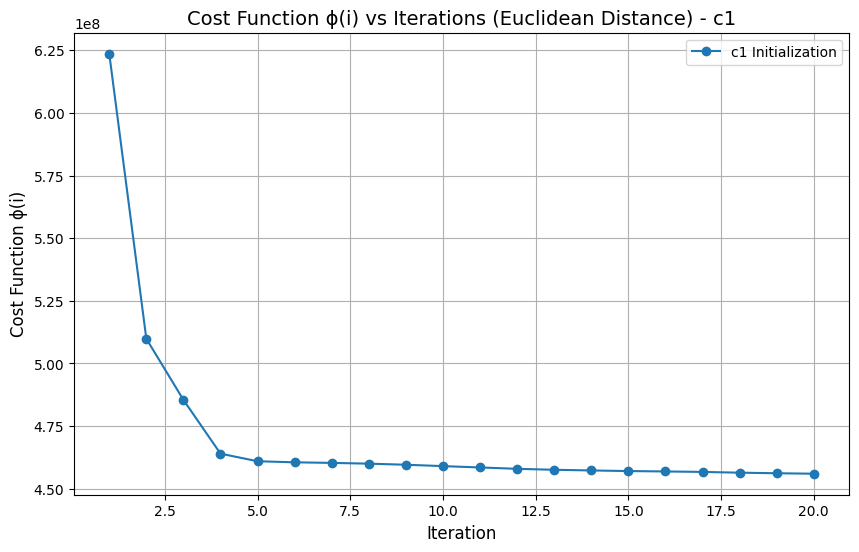

In [17]:
# Generate a plot for c1.txt

# TODO: YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), costs1, label='c1 Initialization', marker='o')
plt.title("Cost Function ϕ(i) vs Iterations (Euclidean Distance) - c1", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost Function ϕ(i)", fontsize=12)
plt.legend()
plt.grid()
plt.show()


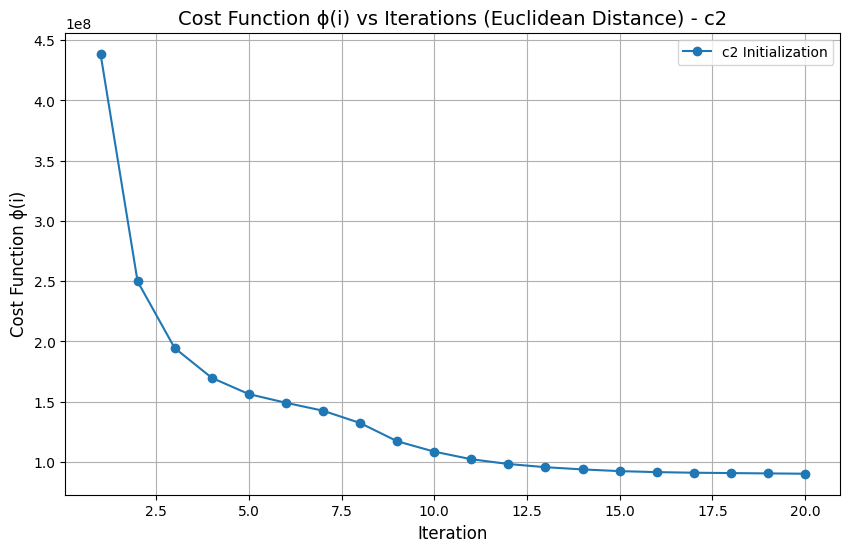

In [18]:
# Generate a plot for c2.txt

# TODO: YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), costs2, label='c2 Initialization', marker='o')
plt.title("Cost Function ϕ(i) vs Iterations (Euclidean Distance) - c2", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost Function ϕ(i)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

### b) Compute percentage change in cost after 10 iterations of the K-Means algorithm.

In [19]:
# percentage change in cost for c1.

# TODO: YOUR CODE HERE
percent_change_c1 = ((costs1[0] - costs1[9]) / costs1[0]) * 100
print(f"Percentage Change in Cost (q2-c1.txt): {percent_change_c1:.2f}%")

Percentage Change in Cost (q2-c1.txt): 26.40%


In [20]:
# percentage change in cost for c2.

# TODO: YOUR CODE HERE
percent_change_c2 = ((costs2[0] - costs2[9]) / costs2[0]) * 100
print(f"Percentage Change in Cost (q2-c2.txt): {percent_change_c2:.2f}%")

Percentage Change in Cost (q2-c2.txt): 75.26%


Use the below cell for your written explanation.

The percentage change in cost after 10 iterations is 26.40% for "q2-c1.txt" (random initialization) and 75.26% for "q2-c2.txt" (systematic initialization). From the graphs, the cost for "q2-c1.txt" starts higher at around \(6.25 * 10^8\) and drops rapidly in the first few iterations, then stabilizes around \(4.5 * 10^8\). On the other hand, for "q2-c2.txt", the cost starts lower at around \(4.5 * 10^8\) and steadily decreases over 10 iterations, reaching about \(1.1 * 10^8\). For Euclidean distance, systematic initialization reduces large distances, resulting in a lower initial cost when compare the performance using c1 or c2.

This difference demonstrates that systematic initialization with "q2-c2.txt" is much more effective. Random initialization ("q2-c1.txt") selects centroids arbitrarily, often resulting in poor starting positions. As a result, the algorithm has to spend more iterations improving the cluster assignments, and the cost reduction is smaller. Systematic initialization ("q2-c2.txt"), where centroids are chosen to be as far apart as possible, provides a better starting point. It ensures the clusters are well-separated from the beginning, leading to faster convergence and a much greater reduction in cost.

In conclusion, systematic initialization using "q2-c2.txt" is far better than random initialization with "q2-c1.txt". It not only starts with a lower cost but also reduces the cost more effectively, making it the preferred method for initializing centroids in the K-Means algorithm.


### c) Using Manhattan distance to compute phi(i) for every iteration i.

In [21]:
# initialize my_kmeans class with Manhattan Distance with centroids c1 and run the K-means algorithm
km1 = my_kmeans(data=documents, centroids = c1, k = 10, max_iter = 20, distance_measure=manhattan_distance)
centroids1, assignments1, costs1 = km1.run_kmeans()

# initialize my_kmeans class with Manhattan Distance with centroids c2 and run the K-means algorithm
km2 = my_kmeans(data=documents, centroids=c2, k=10, max_iter=20, distance_measure=manhattan_distance)
centroids2, assignments2, costs2 = km2.run_kmeans()

In [22]:
# Get a list of costs psi

# TODO: YOUR CODE HERE
list_of_costs1 = costs1
print("List of costs for c1.txt:")
print(list_of_costs1)

list_of_costs2 = costs2
print("List of costs for c2.txt:")
print(list_of_costs2)


List of costs for c1.txt:
[550117.1420000045, 464829.26840394654, 470934.15384668263, 483874.81628509297, 489234.2347883483, 487664.6926267901, 483718.66592851654, 475337.94763305597, 474871.9665496577, 457244.78974174923, 447493.195604051, 450891.8358047716, 451232.5774756949, 451860.12588546367, 451567.2235891512, 452710.0520999444, 453078.22696184984, 450646.13556209754, 450419.97011343326, 449009.59037188475]
List of costs for c2.txt:
[1433739.3099999938, 1084488.7769648738, 973431.7146620394, 895934.5925630673, 865128.3352940796, 845846.6470313473, 827219.5827561237, 803590.3456011107, 756039.5172761244, 717332.9025432297, 694587.9252526843, 684444.5019967926, 674574.7475478566, 667409.469916026, 663556.6278214998, 660162.777228758, 656041.3222947085, 653036.7540731638, 651112.4262522653, 649689.0131843556]


Use the below cell to plot the graphs.

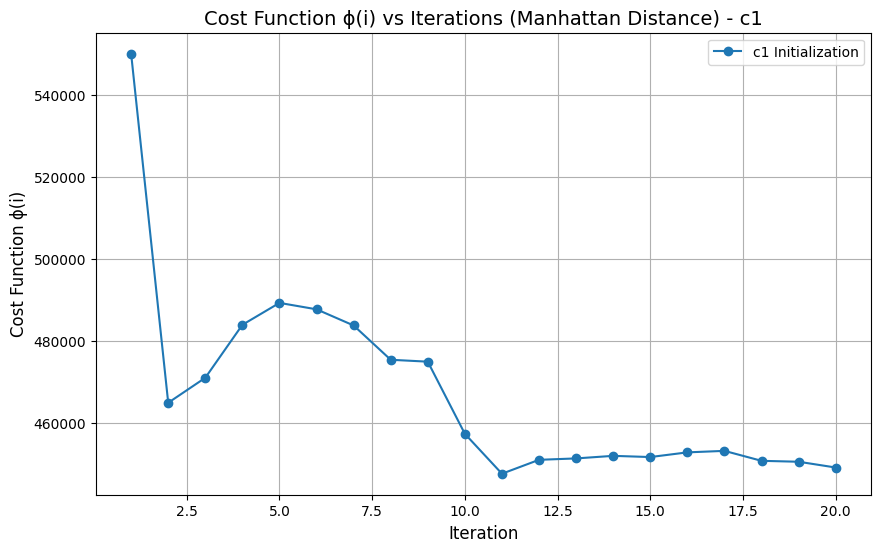

In [23]:
# Generate a plot for c1.txt

# TODO: YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), costs1, label='c1 Initialization', marker='o')
plt.title("Cost Function ϕ(i) vs Iterations (Manhattan Distance) - c1", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost Function ϕ(i)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

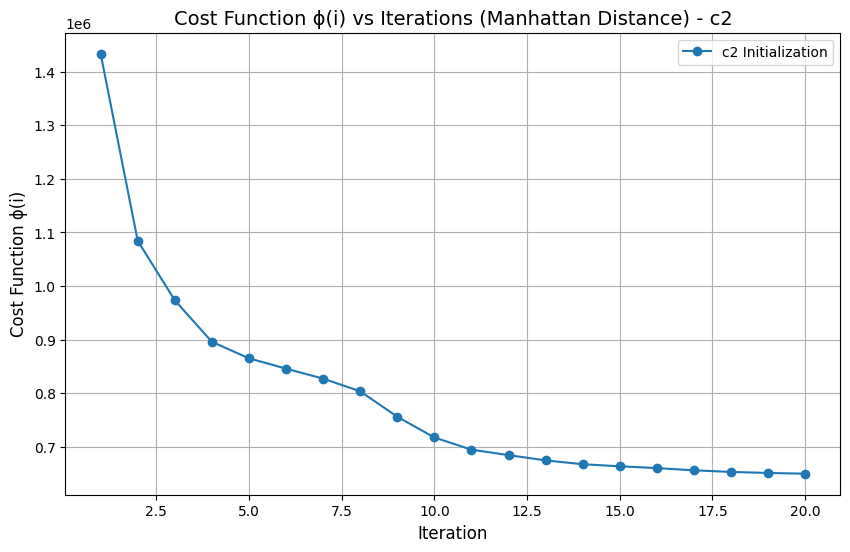

In [24]:
# Generate a plot for c2.txt

# TODO: YOUR CODE HERE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), costs2, label='c2 Initialization', marker='o')
plt.title("Cost Function ϕ(i) vs Iterations (Manhattan Distance) - c2", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost Function ϕ(i)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

### d) Compute percentage change in cost after 10 iterations of the K-Means algorithm.

In [25]:
# percentage change in cost for c1.

# TODO: YOUR CODE HERE
percent_change_c1 = ((costs1[0] - costs1[9]) / costs1[0]) * 100
# Display Results
print(f"Percentage Change in Cost (q2-c1.txt): {percent_change_c1:.2f}%")


Percentage Change in Cost (q2-c1.txt): 16.88%


In [26]:
# percentage change in cost for c2.

# TODO: YOUR CODE HERE
percent_change_c2 = ((costs2[0] - costs2[9]) / costs2[0]) * 100
print(f"Percentage Change in Cost (q2-c2.txt): {percent_change_c2:.2f}%")


Percentage Change in Cost (q2-c2.txt): 49.97%


Use the below cell for your written explanation.

The percentage change in cost after 10 iterations is 16.88% for "q2-c1.txt" (random initialization) and 49.97% for "q2-c2.txt" (systematic initialization). From the graphs, the cost for "q2-c1.txt" starts at around \(5.4 * 10^4\) and drops sharply in the first iteration. However, it fluctuates over the next few iterations before stabilizing around \(4.6 * 10^4\). For "q2-c2.txt," the cost starts higher at approximately \(1.4 * 10^6\) but decreases steadily. It eventually reaches a lower cost of about \(7.0 * 10^4\), without any major fluctuations. For Manhattan distance, systematic initialization increases axis-aligned distances, leading to a higher initial cost when compare the performance using c1 or c2.

The behavior shows that systematic initialization with "q2-c2.txt" is more effective than random initialization with "q2-c1.txt." Random initialization picks centroids arbitrarily, which can result in poor cluster assignments at the beginning. This explains the oscillations in the cost for "q2-c1.txt." In contrast, "q2-c2.txt" chooses centroids as far apart as possible. These extreme positions may result in larger initial distances between the centroids and some points in the dataset, causing a higher initial cost. This improves cluster separation and leads to smoother convergence. The fluctuations in the "q2-c1.txt" graph are due to the Manhattan distance metric. Manhattan distance aligns centroids along grid-like paths. Unlike Euclidean distance, Manhattan distance does not guarantee a monotonic decrease in cost during centroid updates.

In conclusion, systematic initialization using "q2-c2.txt" is better than random initialization with "q2-c1.txt." It achieves a greater cost reduction and avoids the instability seen with random initialization. This makes "q2-c2.txt" the preferred method for initializing centroids, especially when using Manhattan distance.











In [27]:
# stop the spark instance
sc.stop()